In [7]:
import numpy as np
import pandas as pd
from scipy.integrate import ode as ode
from matplotlib import pyplot as plt
#import xlsxwriter
from scipy.optimize import curve_fit
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import os
#from model_vectorised_dg_extended import *
#from ipynb.fs.full.model_vectorised_dg_extended import *
%run model_vectorised_dg_extended.ipynb
os.chdir(os.getcwd())

### Create dictionary, which holds all the experimental setups (Receptor/G-protein/Arrestin overexpression profile of experiment) and all the perturbed process names for given experimental setup 

In [16]:
perturbed_processes=['Koff_Kon_all','Phosphorylation_PM','Phosphorylation_IC','Phosphorylation_IC_PM','Phosphatase_PM','Phosphatase_IC','Phosphatase_IC_PM',
                     'Arrestin_association','Arrestin_dissociation','Internalisation']

perturbed_processes_per_experimental_setup={'receptor_arrestin_overexpression':perturbed_processes,
                                            'receptor_gprotein_overexpression':perturbed_processes[0:1],
                                            'receptor_overexpression':perturbed_processes[0:1],
                                            'physiological':perturbed_processes[0:1]}

### Create folders to save results to
##### 1. Create 'data' folder in parent directory to save the simulation data there
##### 2. Create subfolders for the 4 experimental setups with different molecules overexpressed
##### 3. Create the two main subfolders: with internalisation/no internalisation -> all perturbations of the different processes are performed once with internalisation, once without internalisation
##### 4. Create sub-subfolders for the individual perturbed processess

In [17]:
def create_folder_if_doesnt_exist(path):
    if not os.path.exists(path):
        print('folder created: ',path)
        os.makedirs(path)
    return

## Create data folder
if not os.path.exists('../data'):
    print('folder created: ../data')
    print()
    os.makedirs('../data')

## Create all the subfolders if they don't exist yet
for exp_setup in perturbed_processes_per_experimental_setup.keys():
    path=os.path.join('../data/',exp_setup)
    create_folder_if_doesnt_exist(path)
    
    for intern_dirname in ['With_internalisation','No_internalisation','temp_data_for_plotting']:
        path=os.path.join('../data/',exp_setup,intern_dirname)
        create_folder_if_doesnt_exist(path)

        perturbed_processes=perturbed_processes_per_experimental_setup[exp_setup]
        if intern_dirname=='temp_data_for_plotting':
            continue
        else:
            for process_dirname in perturbed_processes:
                path=os.path.join('../data/',exp_setup,intern_dirname,process_dirname,'')
                if intern_dirname=='No_internalisation' and process_dirname=='Internalisation':
                    continue
                create_folder_if_doesnt_exist(path)


folder created:  ../data/receptor_overexpression
folder created:  ../data/receptor_overexpression/With_internalisation
folder created:  ../data/receptor_overexpression/With_internalisation/Koff_Kon_all/
folder created:  ../data/receptor_overexpression/No_internalisation
folder created:  ../data/receptor_overexpression/No_internalisation/Koff_Kon_all/
folder created:  ../data/receptor_overexpression/temp_data_for_plotting


### Function for running the model

In [14]:
## Function for running the simulation for a given set of parameters
def simulation(exp_setup,intern_status,process_name,ligand_ccs,simulation_time,sim_number,start_time,\
               k_vals_of_perturbed_processes,molecule_cc_per_experimental_setup,num_of_all_simulations,factor=None):

    ## Select the perturbed process out out of perturbed processes dictionary and initialise the Ko Koff values
    kon_values=k_vals_of_perturbed_processes[process_name]['Koff_Kon_perturbations']['kon_values']
    koff_values=k_vals_of_perturbed_processes[process_name]['Koff_Kon_perturbations']['koff_values']
 
    ## Loop over Kon and Koff values
    for a,kon in enumerate(kon_values):
        for b,koff in enumerate(koff_values):
            ## Adjust ligand concentrations according to the changing Koff/Kon ratio (==Kd)-> changing ligand affinity needs changing
            # ligand concentrations to achieve same efficacy (if ligand affinity drops -> ligand concentration needs to 
            # achieve increase for same effect)
            Kd_ratio = (koff/ kon) / (0.0003 / 0.3)
            ligands = ligand_ccs * Kd_ratio

            ## Directory path to save results to
            dirname=os.path.join('../data/',exp_setup,intern_status,process_name,'')

            ## Loop over all the used ligand concentrations
            for ligand in ligands:
                ## Initialise model, and change the necessary rate constants, ligand concentrations
                model = VecModel(0.1)
                model.read('../model/toth_szalai_modified.txt')
                model.change_ccs(molecules_dict['Arrestin'], molecule_cc_per_experimental_setup[exp_setup]['Arrestin'])
                model.change_ccs(molecules_dict['Receptor'], molecule_cc_per_experimental_setup[exp_setup]['Receptor'])
                model.change_ccs(molecules_dict['G-protein'], molecule_cc_per_experimental_setup[exp_setup]['G-protein'])
                model.change_constant(k_vals_of_perturbed_processes[process_name]['Koff_Kon_perturbations']['kon_model_numbers'], kon)
                model.change_constant(k_vals_of_perturbed_processes[process_name]['Koff_Kon_perturbations']['koff_model_numbers'], koff)
                model.change_ccs(molecules_dict['Ligand'], ligand)

                ## In case of no internalisation, set internalisation rate constant to 0
                if intern_status=='No_internalisation':
                    model.change_constant(k_vals_of_perturbed_processes['Internalisation']['k_vals_of_process_in_model'], 0)
        
                ## If there is a cellular process to ber perturbed, multiply the rate constants of the process by the perturbation factor
                if factor !=None:
                    model.multiply_constant_with_factor(k_vals_of_perturbed_processes[process_name]['k_vals_of_process_in_model'], factor)


                ## Simulate the process for one constellation of parameters
                model.simulate(simulation_time)

                ## Print number of simulations and elapsed/remaining time to check on status of the simulation
                sim_number=sim_number+1                
                elapsed_time=(time.time()-start_time)/3600
                remaining_time=((1/(sim_number/num_of_all_simulations))*elapsed_time-elapsed_time)
                print(round(100*sim_number/num_of_all_simulations,2),' % Done ','Elapsed time (h): ',round(elapsed_time,4),
                'Remaining time (h):',round(remaining_time,4),end="")
                print("\r", end="")     

                
                ## Convert concentrations of the molecules into a dataframe and save as csv
                ## Row: time
                ## Columns: concentrations of molecules considered in the simulation
                if factor !=None:
                    fname=dirname+ '_'.join([process_name,str(factor),'koff',str(koff),'kon',str(kon),'ligand_cc',str(round(np.log10(ligand)-6,3))])+'.csv'
                elif factor==None:
                    fname=dirname+ '_'.join([process_name,'koff',str(koff),'kon',str(kon),'ligand_cc',str(round(np.log10(ligand)-6,3))]) + '.csv'
                model.save_to_csv(fname)
      
    return(sim_number)

### Perturbation of Kon-Koff all 

In [15]:
## Dictionary holding the numbers of the molecules in the model (for explanation, look up model-figure.pdf)
molecules_dict={'Arrestin-Receptor':[10,11,12,13,14,15],
                'Ligand':[1,3],
                'Arrestin': [2],
                'Receptor':[4],
                'G-protein':[22]}

## All possible perturbed process names 
perturbed_processes=['Koff_Kon_all','Phosphorylation_PM','Phosphorylation_IC','Phosphorylation_IC_PM','Phosphatase_PM','Phosphatase_IC','Phosphatase_IC_PM',
                     'Arrestin_association','Arrestin_dissociation','Internalisation']

## Dict holding all the perturbed process names for given experimental setup 
perturbed_processes_per_experimental_setup={'receptor_arrestin_overexpression':perturbed_processes,
                                            'receptor_gprotein_overexpression':perturbed_processes[0:1],
                                            'receptor_overexpression':perturbed_processes[0:1],
                                            'physiological':perturbed_processes[0:1]}                                        

## Dictionary holding all the concentrations of receptor,arrestin and G-protein for the given experimental setup
molecule_cc_per_experimental_setup={'receptor_arrestin_overexpression':{'Arrestin':15000,
                                                                        'Receptor':5000,
                                                                        'G-protein':40},
                                    'receptor_gprotein_overexpression':{'Arrestin':1000,
                                                                        'Receptor':5000,
                                                                        'G-protein':4000},
                                    'receptor_overexpression':{'Arrestin':1000,
                                                               'Receptor':5000,
                                                               'G-protein':40},
                                    'physiological':{'Arrestin':1000,
                                                     'Receptor':50,
                                                     'G-protein':40}} 


### Dictionary holding the name of the perturbed processes and the number of perturbed processes that they 
##  are corresponding to in the model (i.e. Kon value of L + R -> LR is K value number 1,5,9,..., check out model-figure.pdf for visual
## explanation)

### In each perturbation round two sets of processes are perturbed:
##  1. Kon-Koff values of the Ligand-Receptor binding
##  2. Other cellular processes (i.e. internalisation, phosphorylation, etc...)
##  By looping this dictionary each 

## 1. "Koff_Kon_perturbations" hold the perturbed values (kon_values,koff_values) but also the number of the Kon-Koff values 
#  in the model (kon_model_numbers,koff_model_numbers)
## 2. "k_vals_of_process_in_model" hold the model numbers for the respective cellular process 


k_vals_of_perturbed_processes={'Koff_Kon_all':{'Koff_Kon_perturbations':{ 'kon_values':[0.03,0.3,3],
                                                                'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                'koff_values':[0.0003,0.001,0.003,0.01,0.03,0.1],
                                                                'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                     'k_vals_of_process_in_model':[]},

                    'Phosphorylation_PM':{'Koff_Kon_perturbations':{'kon_values':[0.3],
                                                                    'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                    'koff_values':[0.0003,0.03,0.1],
                                                                    'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                        'k_vals_of_process_in_model':[30]},

                    'Phosphorylation_IC':{'Koff_Kon_perturbations':{'kon_values':[0.3],
                                                                    'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                    'koff_values':[0.0003,0.03,0.1],
                                                                    'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                        'k_vals_of_process_in_model':[50]},

                    'Phosphorylation_IC_PM':{'Koff_Kon_perturbations':{ 'kon_values':[0.3],
                                                                        'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                        'koff_values':[0.0003,0.03,0.1],
                                                                        'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                            'k_vals_of_process_in_model':[50,30]},

                    'Phosphatase_PM':{'Koff_Kon_perturbations':{'kon_values':[0.3],
                                                                'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                'koff_values':[0.0003,0.03,0.1],
                                                                'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                      'k_vals_of_process_in_model':[25,27,29]},

                    'Phosphatase_IC':{'Koff_Kon_perturbations':{'kon_values':[0.3],
                                                                'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                'koff_values':[0.0003,0.03,0.1],
                                                                'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                      'k_vals_of_process_in_model': [47,48,49]},  

                    'Phosphatase_IC_PM':{'Koff_Kon_perturbations':{ 'kon_values':[0.3],
                                                                    'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                    'koff_values':[0.0003,0.03,0.1],
                                                                    'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                        'k_vals_of_process_in_model': [25,27,29,47,48,49]},

                    'Arrestin_association':{'Koff_Kon_perturbations':{  'kon_values':[0.3],
                                                                        'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                        'koff_values':[0.0003,0.03,0.1],
                                                                        'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                            'k_vals_of_process_in_model': [35,44,36,37,45,46]},

                    'Arrestin_dissociation':{'Koff_Kon_perturbations':{ 'kon_values':[0.3],
                                                                        'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                        'koff_values':[0.0003,0.03,0.1],
                                                                        'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                             'k_vals_of_process_in_model': [32,33,41,42,34,43]},

                    'Internalisation':{'Koff_Kon_perturbations':{   'kon_values':[0.3],
                                                                    'kon_model_numbers':[1,5,9,13,17,21,51,55],
                                                                    'koff_values':[0.0003,0.03,0.1],
                                                                    'koff_model_numbers':[2,6,10,14,18,22,4,8,12,16,20,24,52,56,54,58]},
                                        'k_vals_of_process_in_model': [38, 39, 40]}}



                     
## Determine ligand concentrations              
ligand_ccs=(10 ** np.arange(-6, 1.1, 1))
internalisation_status=['With_internalisation','No_internalisation']

## Simulation time
simulation_time=1200

## List of perturbation factors, that are used for the perturbations of cellular processes ->
## Each rate constant (contained by 'k_vals_of_process_in_model')in the cellular process to be perturbed gets multiplied 
# by this factor to change the process' speed
factor_list=[100,30,10,3,1,0.3,0.1,0.03,0.01]


##### List containing the experimental setups to loop over and run model for
experimental_setups=['receptor_gprotein_overexpression','receptor_overexpression','physiological'] #'receptor_arrestin_overexpression'


##### Calculate the number of all models
num_of_all_simulations=0
for exp_setup in experimental_setups:
    perturbed_processes=perturbed_processes_per_experimental_setup[exp_setup]
    for process in perturbed_processes:
        kon_num=len(k_vals_of_perturbed_processes[process]['Koff_Kon_perturbations']['kon_values'])
        koff_num=len(k_vals_of_perturbed_processes[process]['Koff_Kon_perturbations']['koff_values'])
        if len(k_vals_of_perturbed_processes[process]['k_vals_of_process_in_model'])>0:
            if process=='Internalisation':
                num_of_sim_in_perturbation=kon_num*koff_num*len(factor_list)*len(ligand_ccs)
            if process!='Internalisation':
                num_of_sim_in_perturbation=kon_num*koff_num*len(factor_list)*len(ligand_ccs)*len(internalisation_status)
        elif len(k_vals_of_perturbed_processes[process]['k_vals_of_process_in_model'])==0:
            num_of_sim_in_perturbation=kon_num*koff_num*len(ligand_ccs)*len(internalisation_status)
        num_of_all_simulations=num_of_all_simulations + num_of_sim_in_perturbation


## Keep track of number of simulations already run and elapsed time
import time
sim_number=0
start_time = time.time()

#### RUN MODELS
## Loop over experimental setups and initialise experimental conditions for the model
for exp_setup in experimental_setups:

    ## Select the names of perturbed processes in the given experimental setup
    perturbed_processes=perturbed_processes_per_experimental_setup[exp_setup]

    ## Loop over experimental settings and select parameters for the simulation
    for intern_status in internalisation_status[:]:

        ## Loop over the previously created list of process names that are perturbed in given experimental setup
        for process_name in perturbed_processes:

            ## In the case of no internalisation don't run perturbation of Internalisation process, as internalisation is set to 0.
            if intern_status=='No_internalisation' and process_name=='Internalisation':
                continue
            
            ## If there is a cellular process to be perturbed, loop over the perturbation factors that will be used for rate constant perturbation
            if len(k_vals_of_perturbed_processes[process_name]['k_vals_of_process_in_model'])>0:
                for factor in factor_list:
                    sim_number=simulation(exp_setup,intern_status,process_name,ligand_ccs,simulation_time,sim_number,start_time,\
                                          k_vals_of_perturbed_processes,molecule_cc_per_experimental_setup,num_of_all_simulations,factor=factor)
            
            ## If only Kon-Koff values are perturbed, don't loop over factors
            elif len(k_vals_of_perturbed_processes[process_name]['k_vals_of_process_in_model'])==0:
                sim_number=simulation(exp_setup,intern_status,process_name,ligand_ccs,simulation_time,sim_number,start_time,\
                                      k_vals_of_perturbed_processes,molecule_cc_per_experimental_setup,num_of_all_simulations,factor=None)

print()
print('Simulations done. Runtime (h): ',(time.time()-start_time)/3600)

100.0  % Done  Elapsed time (h):  0.0022 Remaining time (h): 0.0001
Simulations done. Runtime (h):  0.0021988583273357815


In [18]:
num_of_all_simulations

864

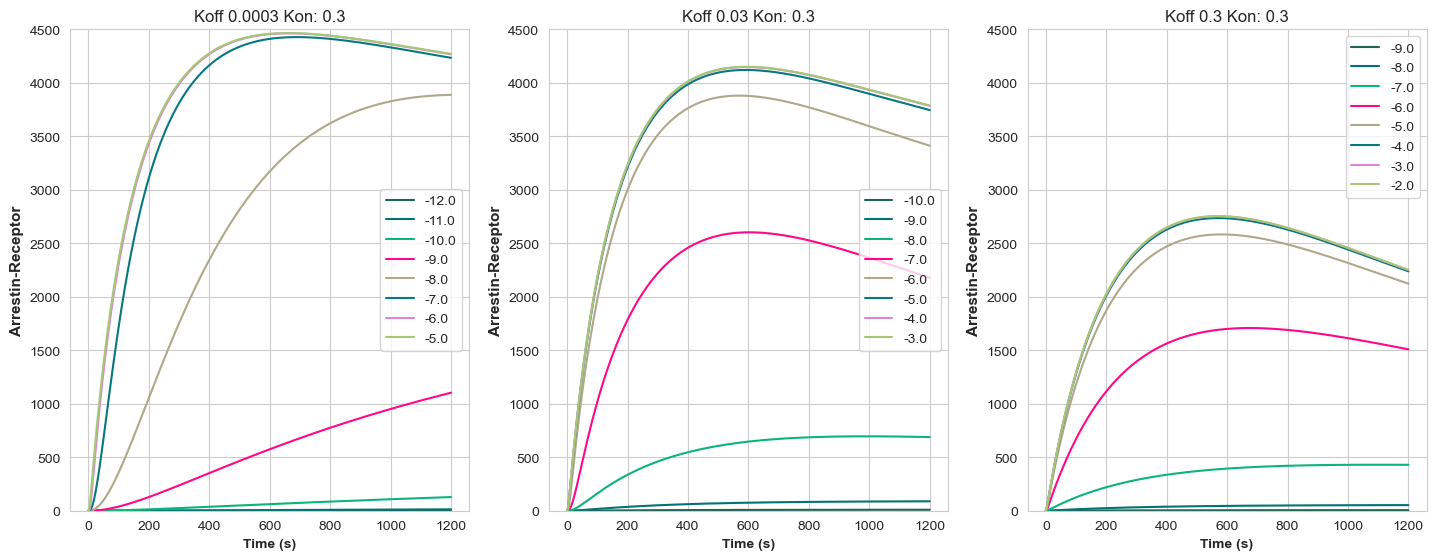

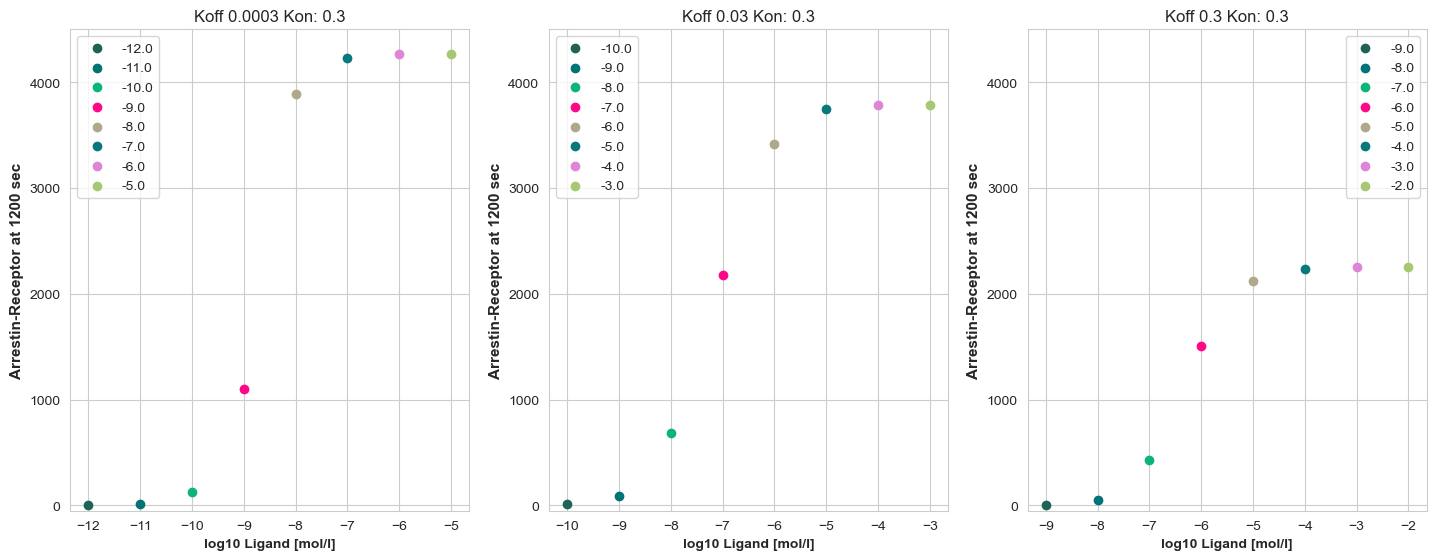

In [5]:
kon=0.3
molecules_dict={'Arrestin-Receptor':[10,11,12,13,14,15],
                'Ligand':[1,3],
                'Arrestin': [2],
                'Receptor':[4]}
process_name='Koff_Kon_all'
dirname='../data/With_internalisation/Koff_Kon_all/'
import matplotlib.colors as mcolors

ligand_ccs=(10 ** np.arange(-6, 1.1, 1))
fig,ax=plt.subplots(1,3,figsize=(17.5,6.25))
fig2,ax2=plt.subplots(1,3,figsize=(17.5,6.25))
for n,koff in enumerate([0.0003,0.03,0.3]):
    
    Kd_ratio = (koff/ kon) / (0.0003 / 0.3)
    ligands = ligand_ccs * Kd_ratio
    ligands=(np.log10(ligands) - 6)
    colors=[*mcolors.XKCD_COLORS][25:25+len(ligands)]
    for ligand,color in zip(ligands,colors):
        fname=dirname+ '_'.join([process_name,'koff',str(koff),'kon',str(kon),'ligand_cc',str(ligand)]) + '.csv'
        col_nums=[int(x+1) for x in molecules_dict['Arrestin-Receptor']]
        col_nums.append(0)
        arr_receptor_df=pd.read_csv(fname, index_col=0,usecols=col_nums)
        ax[n].plot(arr_receptor_df.index.tolist(),np.sum(arr_receptor_df.loc[:,:],1),label=ligand,color=mcolors.XKCD_COLORS[color])
        ax2[n].scatter(ligand,np.sum(arr_receptor_df.iloc[-1,:]),label=ligand,color=mcolors.XKCD_COLORS[color])
    ax[n].legend()
    title=' '.join(['Koff',str(koff),'Kon:',str(kon)])
    ax[n].set_title(title)
    ax[n].set_xlabel('Time (s)',fontweight="bold")
    ax[n].set_ylabel('Arrestin-Receptor',fontweight="bold",fontsize=11)
    ax[n].set_ylim(0,4500)
    ax2[n].legend(ligands)
    ax2[n].set_title(title)
    ax2[n].set_xlabel('log10 Ligand [mol/l]',fontweight="bold")
    ax2[n].set_ylabel('Arrestin-Receptor at '+str(int(arr_receptor_df.index.tolist()[-1])) +' sec',fontweight="bold",fontsize=11)
    ax2[n].set_ylim(-50,4500)
fig.savefig('../data/control_figs/plot2.png',dpi=300)
fig2.savefig('../data/control_figs/plot3.png',dpi=300)